In [25]:
import pandas as pd

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import rdFMCS as fmcs

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.cluster import BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
# load dataset
original_data = pdt.LoadSDF('chembl_data_sdf/CHEMBL244_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# drop unnecessary information
print(original_data.nunique())
# std_type jest jedyny, nie musimy go uwzględniać
# podobnie target_id target_name target_type organism i ID
# std_unit jest jedyny, nie należy go uwzględniać ani konwertować std_value
original_data = original_data.drop(['CdId','Mol Weight','Formula','target_id','target_name','organism','target_type','ID','std_unit','std_type'],axis=1)
original_data.tail() # sprawdzić czy dane wyglądają OK

CdId             4226
Mol Weight       3057
Formula          3074
cmpd_chemblid    4226
std_type            1
std_value        1038
std_unit            1
target_id           1
target_name         1
organism            1
target_type         1
ID                  1
smiles           4225
dtype: int64


,cmpd_chemblid,std_value,smiles
4221,CHEMBL427842,2.6,O=C(N[C@H]1CCC[C@H]1NC(=O)c1ccc2c(Cl)c[nH]c2c1...
4222,CHEMBL1761614,305.0,CN1CCc2nc(C(=O)NC[C@@H](CC(=O)O)NC(=O)c3cc4cc(...
4223,CHEMBL272042,32.0,CCOC(=O)CN(CCCS(=O)(=O)c1ccc2cc(Cl)ccc2c1)C(=O...
4224,CHEMBL539053,40.0,CC(=N)N1CC[C@H](Oc2ccc([C@H](Cc3ccc4ccc(C(=N)N...
4225,CHEMBL371336,4.25,Nc1cc(C(=O)NC[C@H]2CN(c3ccc(N4CCOCC4=O)cc3)C(=...


In [4]:
# przygotowanie danych poprzez skalowanie
# jeżeli dane mają dystrybucję normalną
def gaussianScaler(numArr):
    # standard gaussian scaler
    # X' = (X-mu)/sigma
    mean = numArr.mean()
    std = numArr.std()
    numArr = (numArr - mean) / std
    return numArr

# jeżeli dane podążają za 'power law' (~e^x)
def logScaler(numArr):
    # standard logarythmic scaler
    numArr = np.log(numArr)
    return numArr

# jeżeli dystrybucja jest niejasna
# dane dzielimy na kwantyle
def createQuantiles(dfColumn, numQuantiles):
    # create as many quantiles as wanted
    return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

# i normalizujemy minmaxem
def minMaxScaler(numArr):
    # standard minmax scaler
    minx = np.min(numArr)
    maxx = np.max(numArr)
    # linearly map all values from minimal to maximal
    # to values ranging from 0 to 1
    numArr = (numArr - minx) / (maxx - minx)
    return numArr

class Featurizer:
    def __init__(self, smiles_col='smiles', activity_col='std_value', **kwargs):
        self.smiles_col = smiles_col
        self.activity_col = activity_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

class ClusteringFeaturizer(Featurizer):
    def __init__(self, activity_dist='gaussian', qcount=0, radius=2, length=1024, **kwargs):
        self.activity_dist = activity_dist
        self.qcount = qcount
        self.radius = radius
        self.length = length
        super().__init__(**kwargs)
    
    def __call__(self, df,quick=False):
        ## check if valid arguments
        # check activity distribution
        if(self.activity_dist != 'gaussian' and self.activity_dist != 'powerlaw' and self.activity_dist != 'quantiles'):
            print('wrongly set attribute activity_dist. Please use one of the following:\ngaussian, powerlaw, quantiles')
            return pd.DataFrame()
        # if quantiles are selected, there must be at least two of them
        if(self.activity_dist == 'quantiles' and self.qcount < 2):
            print('wrongly set quantile count.')
            return pd.DataFrame()
        # reconvert everything to float in order to prepare for scaling
        df[self.activity_col] = df[self.activity_col].astype(float)
        # generate column names for features in morgan fingerprints
        c = ['activity']+['f_'+str(n) for n in np.arange(self.length)]
        ## quick will eat more memory
        if quick:
            features = []
        else:
            features = pd.DataFrame(columns=c)
        ## prepare activity by scaling the data with scaler
        # chosen to the selected distribution
        match self.activity_dist:
            case 'gaussian':
                df[self.activity_col] = gaussianSacler(df[self.activity_col])
            case 'powerlaw':
                df[self.activity_col] = logScaler(df[self.activity_col])
            case 'quantiles':
                df[self.activity_col] = createQuantiles(df[self.activity_col], self.qcount)
                df[self.activity_col] = minMaxScaler(df[self.activity_col])
            case _:
                #do nothing
                return
        ## generate features
        for i, row in df.iterrows():
            smiles = row[self.smiles_col]
            activity = row[self.activity_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            # vector containing morgan fingerprints
            fpvector = np.array(fp,dtype=int)
            # vector representing the molecule, contains
            # fingerprints and activity in floats
            vec = np.array([np.hstack(([activity],fpvector))],dtype=float)
            if quick:
                features.append(vec)
            else:
                fta = pd.DataFrame(vec,columns=c)
                features = pd.concat([features,fta],ignore_index=True)
        return features

<AxesSubplot:xlabel='std_value', ylabel='Density'>

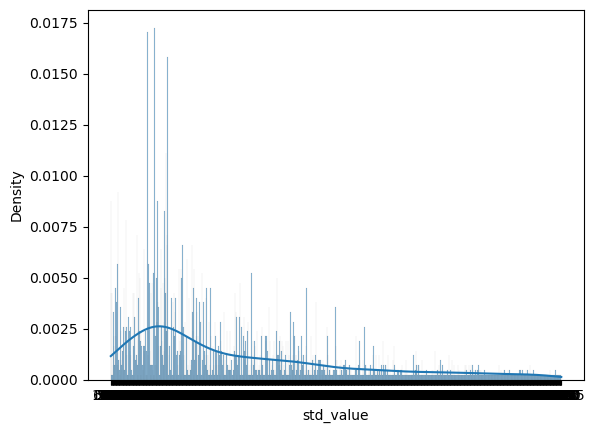

In [4]:
# sprawdzam dystrybucję danych do skalowania
# w tym wypadku jest to std_value albo aktywność związku
sns.histplot(original_data['std_value'],kde=True,stat='density')
# dane nie mają rozróżnialnej dystrybucji, dla najlepszych efektów warto użyć kwantyli

In [5]:
feature_count = 1024
quantile_count = 80
featurizer = ClusteringFeaturizer(activity_dist='quantiles',qcount=quantile_count,length=feature_count)
feature_count = (feature_count + 1) * 1.0 # + activity ; konwersja na float
data = featurizer(original_data)

/tmp/ipykernel_2014/3449602723.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features = pd.concat([features,fta],ignore_index=True)


In [54]:
#clcard = []
clserrm = []
clserrd = []
clserrmb = []
clserrdb = []
print("running cluster cardinality: ")
for i in range(4,40,2):
    res = []
    resb = []
    print(i,end=",")
    for _ in range(5):
        cl = BisectingKMeans(n_clusters=i)
        clds = cl.fit_transform(data)
        clid = cl.labels_
        res.append(silhouette_score(data, cl.labels_))
        resb.append(np.sum(clds[np.arange(clds.shape[0]),clid]))
    clserrm.append(np.mean(res))
    clserrd.append(np.std(res))
    
    clserrmb.append(np.mean(resb))
    clserrdb.append(np.std(resb))
print("done")

running cluster cardinality: 
4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,done


Text(0, 0.5, 'Score')

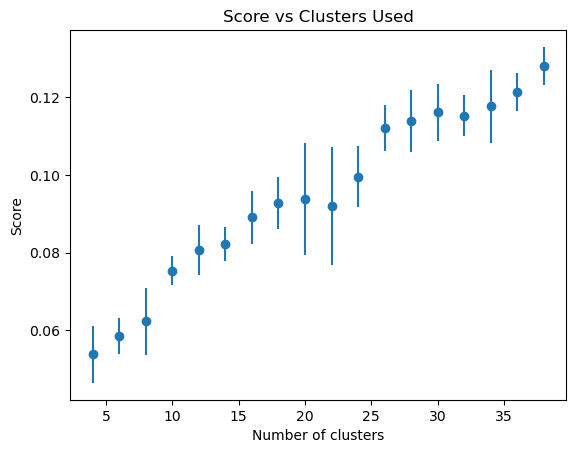

In [55]:
plt.errorbar(range(4,40,2), clserrm,clserrd,linestyle='None',fmt='o')
plt.title('Score vs Clusters Used')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

Text(0, 0.5, 'Distance')

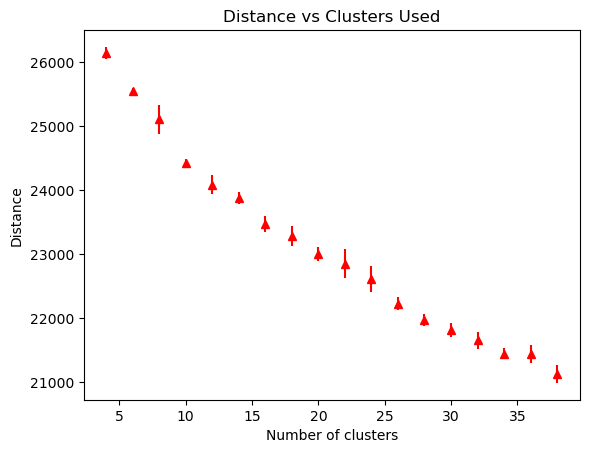

In [56]:
plt.errorbar(range(4,40,2), clserrmb,clserrdb,linestyle='None',fmt='^',c='red')
plt.title('Distance vs Clusters Used')
plt.xlabel('Number of clusters')
plt.ylabel('Distance')

In [57]:
clustering = BisectingKMeans(n_clusters=26)
clustering.fit(data)

BisectingKMeans(n_clusters=26)

In [58]:
clusterid = clustering.labels_
clusterdist = clustering.transform(data)[np.arange(len(data)),clusterid]

In [59]:
processed_data = data.copy()
processed_data['centroid'] = clusterid
original_data['centroid'] = clusterid
processed_data['distance'] = clusterdist
original_data['distance'] = clusterdist
processed_data.tail()

,activity,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1016,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023,centroid,distance
4221,0.282051,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13,5.948493
4222,0.858974,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,4.514825
4223,0.602564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17,5.779095
4224,0.615385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4,4.646016
4225,0.346154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14,4.405133


In [60]:
from ipywidgets import interact

def show_molecule(smiles=''):
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    if not mol:
        return
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    mblock = Chem.MolToMolBlock(mol, kekulize=False)

    # 3D VIEW:
    #view = py3Dmol.view(width=800, height=500)
    #view.addModel(Chem.MolToMolBlock(mol, kekulize=True), 'mol')
    #view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    #view.zoomTo({'model': -1})
    #view.show()

original_data = original_data.sort_values(by=['distance'])
processed_data = processed_data.sort_values(by=['distance'])

@interact(cid=(0,12),eid=(0,100))
def examine_cluster(cid=0,eid=0):
    centroid = original_data.loc[processed_data['centroid'] == cid, :]
    print(original_data['distance'].iloc[eid])
    mol = centroid['smiles']
    #mol = mol.reset_index()
    show_molecule(mol.iloc[eid])

interactive(children=(IntSlider(value=0, description='cid', max=12), IntSlider(value=0, description='eid'), Ou…

In [61]:
pca = PCA(n_components=3)
pcdata3d = pd.DataFrame(pca.fit_transform(processed_data.drop(["centroid","distance"], axis=1)))
pcdata3d.columns = ["pc1", "pc2", "pc3"]
pcdata3d

,pc1,pc2,pc3
0,-2.769116,-0.403619,-1.304945
1,-2.613199,-0.088821,-1.270721
2,-2.838154,-0.486986,-1.241470
3,-2.837284,-0.489484,-1.242713
4,-2.840472,-0.480325,-1.238156
...,...,...,...
4221,0.381014,-0.494798,0.021657
4222,-0.002507,0.602677,-0.459003
4223,-0.063656,0.126970,0.750096
4224,-0.552996,-0.047985,0.366179


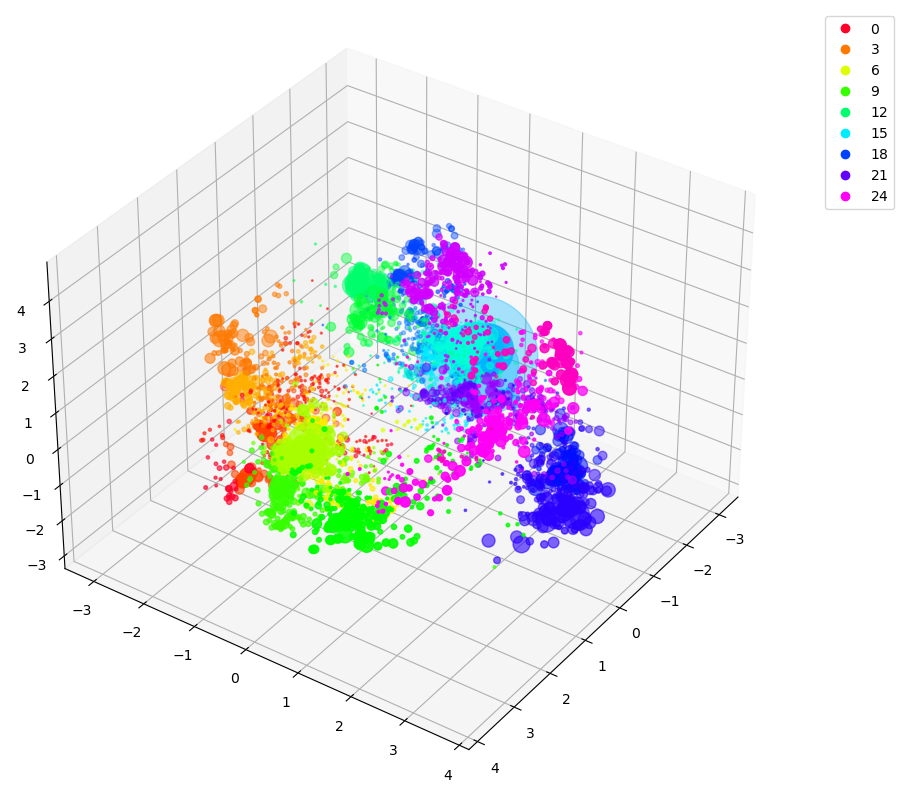

In [62]:
sizes = np.power(10,6)/np.power(processed_data["distance"],7)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.azim = 35
ax.elev = 35
sc = ax.scatter(pcdata3d["pc1"],pcdata3d["pc2"],pcdata3d["pc3"],cmap=plt.cm.gist_rainbow,c=processed_data["centroid"],s=sizes)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

In [64]:
def getAtoms(df):
    mols = []
    for row in df:
        smiles = row
        mol = Chem.MolFromSmiles(smiles)
        mols.append(mol)
    return mols

@interact(cid=(0,11))
def findmcs(cid=0):
    centroid = original_data.loc[processed_data['centroid'] == cid, :]
    act = centroid['std_value']
    dst = centroid['distance']
    mol = centroid['smiles'][:10]
    if (mol.empty or mol.size < 2):
        print("cluster did not converge close enough")
        plt.scatter(dst,act)
        plt.show()
    else:
        mol = mol.reset_index(drop=True)
        #print(mol)
        mcs = Chem.MolFromSmarts(fmcs.FindMCS(getAtoms(mol)).smartsString)
        plt.scatter(dst,act)
        plt.show()
        img = Chem.Draw.MolToImage(mcs)
        return img

interactive(children=(IntSlider(value=0, description='cid', max=11), Output()), _dom_classes=('widget-interact…